# ***Table of contents***


1.   First Approach: Deep Learning Model with Direct Annotations.
2.   Second Approach: Image Processing with No Annotations.
3.   Feature Work!




# **First Approach: Deep Learning Model (SSD)**

My first approach to tackle this problem is to consider at as an object detection problem. I decided to deal with it as an object detection problem because the text in the required region to be replaced with the background color is a text written in Req'aa (خط الرقعة).

To my knowledge there is not OCR model that is trained on Req'aa font, so it is appropriate to deal with the problem as an object detection problem.

I chose a pretrianed SSD300 model (Single Shot Detection).

SSD512 is model has an input size of 300x300 pixels. It can detect smaller objects accurately.

My choice of the SSD model over the the YOLO model is the size of the data at hand.

The SSD model does not the amount of data that the YOLO model require. Additionally the YOLO model can sacrifice some accuracy for the sake of speed, which is not needed in our case (Even in the case of real-time footage, the SSD model is the only model that is capable of achieveing 70% mAP while being a 46 fps real-time model).


The SSD object detection is composed of 2 parts:

Extract feature maps, and apply convolution filters to detect objects.


Small convolutional filters to predict object classes and offsets to default boundary boxes.
Separate filters for default boxes to handle the difference in aspect ratios.
Multi-scale feature maps for object detection.
SSD can be trained end-to-end for better accuracy. SSD makes more predictions and has better coverage on location, scale, and aspect ratios. By removing the delegated region proposal and using lower resolution images.


The archtitcute:

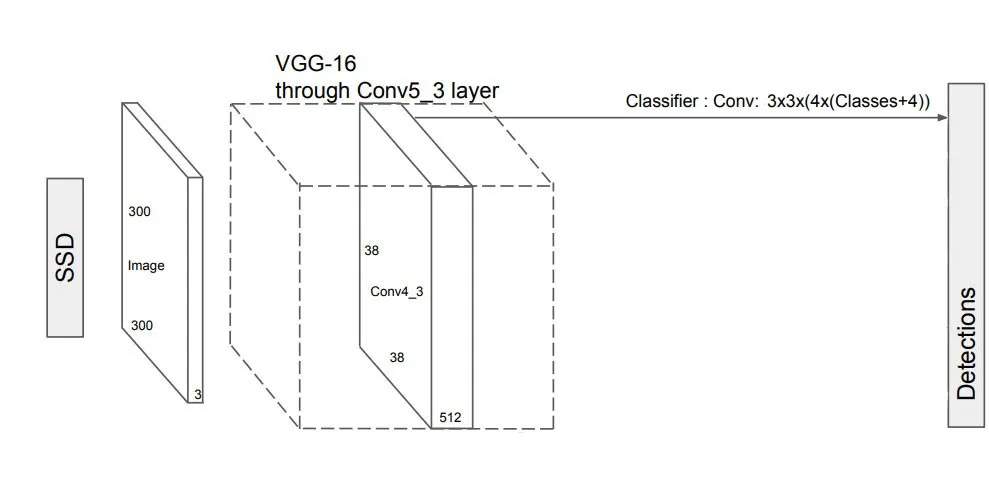

In [ ]:
!pip install torch torchvision torchmetrics scikit-learn tqdm matplotlib opencv-python-headless

import cv2
import xml.etree.ElementTree as ET
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir /content/images
!unzip -q /content/gdrive/MyDrive/efg-input.zip -d /content/images/all
!mkdir /content/images/train; mkdir /content/images/validation; mkdir /content/images/test
!mkdir /content/outputs

mkdir: cannot create directory ‘/content/outputs’: File exists


In [ ]:
# Define the directory containing both images and annotation files
data_dir = '/content/images/all/efg-input'

# Get the list of all files in the directory
all_files = os.listdir(data_dir)

# Separate image files and annotation files
image_files = [f for f in all_files if f.endswith('.jpg') or f.endswith('.png')]
annotation_files = [f for f in all_files if f.endswith('.xml')]

# Make sure we have the same number of images and annotations
assert len(image_files) == len(annotation_files), "Number of images and annotations must be the same"

def enhance_green_in_hsv(image):
    """Enhance green color in the image using HSV color space."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define range for green color and create a mask
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    hsv[mask > 0, 1] = 255  # Increase saturation where green is detected
    hsv[mask > 0, 2] = 255  # Increase brightness where green is detected
    enhanced_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return enhanced_image

def resize_image_and_boxes(image, boxes, new_size):
    """Resize the image and adjust bounding boxes."""
    h, w = image.shape[:2]
    resized_image = cv2.resize(image, new_size)
    resized_boxes = []
    for box in boxes:
        xmin = int(box[0] * new_size[0] / w)
        ymin = int(box[1] * new_size[1] / h)
        xmax = int(box[2] * new_size[0] / w)
        ymax = int(box[3] * new_size[1] / h)
        resized_boxes.append([xmin, ymin, xmax, ymax])
    return resized_image, resized_boxes

# For each image file
for i, image_file in enumerate(image_files):
    # Load the image
    image_path = os.path.join(data_dir, image_file)
    image = cv2.imread(image_path)

    # Check if the image was loaded correctly
    if image is None:
        print(f"Error loading image: {image_path}")
        continue

    # Load the annotation
    annotation_file = image_file[:-4] + '.xml'
    annotation_path = os.path.join(data_dir, annotation_file)
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Get the bounding box coordinates
    boxes = []
    for box in root.iter('bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])

    # Enhance green color and save
    enhanced_image = enhance_green_in_hsv(image)
    enhanced_image_name = f'enhanced_green_{i}_{image_file}'
    cv2.imwrite(os.path.join(data_dir, enhanced_image_name), enhanced_image)
    enhanced_annotation_name = f'enhanced_green_{i}_{image_file[:-4]}.xml'
    new_tree = ET.ElementTree(ET.Element("annotation"))
    new_root = new_tree.getroot()
    for element in root:
        new_root.append(element)
    new_tree.write(os.path.join(data_dir, enhanced_annotation_name))

    # Resize augmentation and save
    new_size = (300, 300)  # Example new size
    resized_image, resized_boxes = resize_image_and_boxes(image, boxes, new_size)
    resized_image_name = f'resized_{new_size[0]}x{new_size[1]}_{i}_{image_file}'
    cv2.imwrite(os.path.join(data_dir, resized_image_name), resized_image)
    resized_annotation_name = f'resized_{new_size[0]}x{new_size[1]}_{i}_{image_file[:-4]}.xml'
    new_tree = ET.ElementTree(ET.Element("annotation"))
    new_root = new_tree.getroot()
    for element in root:
        new_root.append(element)
    for idx, box in enumerate(new_tree.iter('bndbox')):
        box.find('xmin').text = str(resized_boxes[idx][0])
        box.find('xmax').text = str(resized_boxes[idx][2])
        box.find('ymin').text = str(resized_boxes[idx][1])
        box.find('ymax').text = str(resized_boxes[idx][3])
    new_tree.write(os.path.join(data_dir, resized_annotation_name))

print("Augmentation complete.")

Augmentation complete.


In [ ]:


# Directories
input_dir = '/content/images/all/efg-input'
train_dir = '/content/images/train'
val_dir = '/content/images/validation'
test_dir = '/content/images/test'


# Get list of image files and corresponding XML annotation files
images = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))]
annotations = [f.replace('.jpg', '.xml').replace('.png', '.xml') for f in images]

# Ensure each image has a corresponding annotation file
data_pairs = [(img, ann) for img, ann in zip(images, annotations) if os.path.exists(os.path.join(input_dir, ann))]

# Split data into train, val, and test sets
train_pairs, temp_pairs = train_test_split(data_pairs, test_size=0.2, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.33, random_state=42) # 0.33 of 0.3 is approximately 0.1

def move_files(pairs, destination_dir):
    for img, ann in pairs:
        shutil.move(os.path.join(input_dir, img), os.path.join(destination_dir, img))
        shutil.move(os.path.join(input_dir, ann), os.path.join(destination_dir, ann))

# Move files to corresponding directories
move_files(train_pairs, train_dir)
move_files(val_pairs, val_dir)
move_files(test_pairs, test_dir)

print("Data has been split and moved to train, val, and test directories.")

Data has been split and moved to train, val, and test directories.


In [ ]:


BATCH_SIZE = 8 # Increase / decrease according to GPU memeory.
RESIZE_TO = 640 # Resize the image for training and transforms.
NUM_EPOCHS = 15 # Number of epochs to train for.
NUM_WORKERS = 4 # Number of parallel workers for data loading.

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Training images and XML files directory.
TRAIN_DIR = '/content/images/train'
# Validation images and XML files directory.
VALID_DIR = '/content/images/validation'

# Classes: 0 index is reserved for background.
CLASSES = [
    '__background__', 'area'
]

NUM_CLASSES = len(CLASSES)

# Whether to visualize images after crearing the data loaders.
VISUALIZE_TRANSFORMED_IMAGES = False

# Location to save model and plots.
OUT_DIR = '/content/outputs'

In [ ]:
import albumentations as A
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2


plt.style.use('ggplot')

# This class keeps track of the training and validation loss values
# and helps to get the average for each epoch as well.
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation mAP @0.5:0.95 IoU higher than the previous highest, then save the
    model state.
    """
    def __init__(
        self, best_valid_map=float(0)
    ):
        self.best_valid_map = best_valid_map

    def __call__(
        self,
        model,
        current_valid_map,
        epoch,
        OUT_DIR,
    ):
        if current_valid_map > self.best_valid_map:
            self.best_valid_map = current_valid_map
            print(f"\nBEST VALIDATION mAP: {self.best_valid_map}")
            print(f"\nSAVING BEST MODEL FOR EPOCH: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                }, f"{OUT_DIR}/best_model.pth")

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# Define the training tranforms.
def get_train_transform():
    return A.Compose([
        A.Blur(blur_limit=3, p=0.1),
        A.MotionBlur(blur_limit=3, p=0.1),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.ToGray(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.ColorJitter(p=0.3),
        A.RandomGamma(p=0.3),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# Define the validation transforms.
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })


def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """

    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
                cv2.putText(sample, CLASSES[labels[box_num]],
                            (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/last_model.pth')

def save_loss_plot(
    OUT_DIR,
    train_loss_list,
    x_label='iterations',
    y_label='train loss',
    save_name='train_loss'
):
    """
    Function to save both train loss graph.

    :param OUT_DIR: Path to save the graphs.
    :param train_loss_list: List containing the training loss values.
    """
    figure_1 = plt.figure(figsize=(10, 7), num=1, clear=True)
    train_ax = figure_1.add_subplot()
    train_ax.plot(train_loss_list, color='tab:blue')
    train_ax.set_xlabel(x_label)
    train_ax.set_ylabel(y_label)
    figure_1.savefig(f"{OUT_DIR}/{save_name}.png")
    print('SAVING PLOTS COMPLETE...')

def save_mAP(OUT_DIR, map_05, map):
    """
    Saves the mAP@0.5 and mAP@0.5:0.95 per epoch.
    :param OUT_DIR: Path to save the graphs.
    :param map_05: List containing mAP values at 0.5 IoU.
    :param map: List containing mAP values at 0.5:0.95 IoU.
    """
    figure = plt.figure(figsize=(10, 7), num=1, clear=True)
    ax = figure.add_subplot()
    ax.plot(
        map_05, color='tab:orange', linestyle='-',
        label='mAP@0.5'
    )
    ax.plot(
        map, color='tab:red', linestyle='-',
        label='mAP@0.5:0.95'
    )
    ax.set_xlabel('Epochs')
    ax.set_ylabel('mAP')
    ax.legend()
    figure.savefig(f"{OUT_DIR}/map.png")

In [ ]:


def create_model(num_classes=2, size=300):
    # Load the Torchvision pretrained model.
    model = torchvision.models.detection.ssd300_vgg16(
        weights=SSD300_VGG16_Weights.COCO_V1
    )
    # Retrieve the list of input channels.
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    # List containing number of anchors based on aspect ratios.
    num_anchors = model.anchor_generator.num_anchors_per_location()
    # The classification head.
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes,
    )
    # Image size for transforms.
    model.transform.min_size = (size,)
    model.transform.max_size = size
    return model

if __name__ == '__main__':
    model = create_model(2, 640)
    print(model)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
# The dataset class.
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        self.image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm', '*.JPG']
        self.all_image_paths = []

        # Get all the image paths in sorted order.
        for file_type in self.image_file_types:
            self.all_image_paths.extend(glob.glob(os.path.join(self.dir_path, file_type)))
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # Capture the image name and the full image path.
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # Read and preprocess the image.
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # Capture the corresponding XML file for getting the annotations.
        annot_filename = os.path.splitext(image_name)[0] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = ET.parse(annot_file_path)
        root = tree.getroot()

        # Original image width and height.
        image_width = image.shape[1]
        image_height = image.shape[0]

        # Box coordinates for xml files are extracted
        # and corrected for image size given.
        for member in root.findall('object'):
            # Get label and map the `classes`.
            labels.append(self.classes.index(member.find('name').text))

            # Left corner x-coordinates.
            xmin = int(member.find('bndbox').find('xmin').text)
            # Right corner x-coordinates.
            xmax = int(member.find('bndbox').find('xmax').text)
            # Left corner y-coordinates.
            ymin = int(member.find('bndbox').find('ymin').text)
            # Right corner y-coordinates.
            ymax = int(member.find('bndbox').find('ymax').text)

            # Resize the bounding boxes according
            # to resized image `width`, `height`.
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height

            # Check that all coordinates are within the image.
            if xmax_final > self.width:
                xmax_final = self.width
            if ymax_final > self.height:
                ymax_final = self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        # Bounding box to tensor.
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Area of the bounding boxes.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 \
            else torch.as_tensor(boxes, dtype=torch.float32)
        # No crowd instances.
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # Labels to tensor.
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Prepare the final `target` dictionary.
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # Apply the image transforms.
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        if np.isnan((target['boxes']).numpy()).any() or target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.zeros((0, 4), dtype=torch.int64)
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# Prepare the final datasets and data loaders.
def create_train_dataset(DIR):
    train_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
    )
    return train_dataset
def create_valid_dataset(DIR):
    valid_dataset = CustomDataset(
        DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
    )
    return valid_dataset
def create_train_loader(train_dataset, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=0):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return valid_loader


# execute `datasets.py`` using Python command from
# Terminal to visualize sample images
# USAGE: python datasets.py
if __name__ == '__main__':
    # sanity check of the Dataset pipeline with sample visualization
    dataset = CustomDataset(
        TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
    )
    print(f"Number of training images: {len(dataset)}")

    # function to visualize a single sample
    def visualize_sample(image, target):
        for box_num in range(len(target['boxes'])):
            box = target['boxes'][box_num]
            label = CLASSES[target['labels'][box_num]]
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            cv2.rectangle(
                image,
                (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                (0, 0, 255),
                2
            )
            cv2.putText(
                image,
                label,
                (int(box[0]), int(box[1]-5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 0, 255),
                2
            )

        cv2.waitKey(0)

    NUM_SAMPLES_TO_VISUALIZE = 5
    for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = dataset[i]
        visualize_sample(image, target)

Number of training images: 141


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Number of training samples: 141
Number of validation samples: 24

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_siz

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch #1 train loss: 6.105
Epoch #1 mAP: 0.6535101532936096
Took 0.232 minutes for epoch 0

BEST VALIDATION mAP: 0.6535101532936096

SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...

EPOCH 2 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #2 train loss: 3.420
Epoch #2 mAP: 0.8155893087387085
Took 0.521 minutes for epoch 1

BEST VALIDATION mAP: 0.8155893087387085

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...

EPOCH 3 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


Epoch #3 train loss: 2.995
Epoch #3 mAP: 0.8752729296684265
Took 1.351 minutes for epoch 2

BEST VALIDATION mAP: 0.8752729296684265

SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...

EPOCH 4 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #4 train loss: 2.753
Epoch #4 mAP: 0.8878300189971924
Took 0.237 minutes for epoch 3

BEST VALIDATION mAP: 0.8878300189971924

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...

EPOCH 5 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #5 train loss: 2.525
Epoch #5 mAP: 0.8661656975746155
Took 0.578 minutes for epoch 4
SAVING PLOTS COMPLETE...

EPOCH 6 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #6 train loss: 2.364
Epoch #6 mAP: 0.8999999761581421
Took 0.179 minutes for epoch 5

BEST VALIDATION mAP: 0.8999999761581421

SAVING BEST MODEL FOR EPOCH: 6

SAVING PLOTS COMPLETE...

EPOCH 7 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #7 train loss: 2.205
Epoch #7 mAP: 0.890805184841156
Took 0.602 minutes for epoch 6
SAVING PLOTS COMPLETE...

EPOCH 8 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #8 train loss: 2.049
Epoch #8 mAP: 0.8964055180549622
Took 0.615 minutes for epoch 7
SAVING PLOTS COMPLETE...

EPOCH 9 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #9 train loss: 1.929
Epoch #9 mAP: 0.8890256881713867
Took 0.198 minutes for epoch 8
SAVING PLOTS COMPLETE...

EPOCH 10 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239

Epoch #10 train loss: 1.810
Epoch #10 mAP: 0.8862791657447815
Took 3.316 minutes for epoch 9
SAVING PLOTS COMPLETE...

EPOCH 11 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #11 train loss: 1.683
Epoch #11 mAP: 0.8864686489105225
Took 0.510 minutes for epoch 10
SAVING PLOTS COMPLETE...

EPOCH 12 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb51d46db40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb51d46db40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7eb51d46db40>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/d

Epoch #12 train loss: 1.573
Epoch #12 mAP: 0.8808745741844177
Took 0.186 minutes for epoch 11
SAVING PLOTS COMPLETE...

EPOCH 13 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #13 train loss: 1.470
Epoch #13 mAP: 0.890387773513794
Took 0.242 minutes for epoch 12
SAVING PLOTS COMPLETE...

EPOCH 14 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #14 train loss: 1.366
Epoch #14 mAP: 0.8819095492362976
Took 0.529 minutes for epoch 13
SAVING PLOTS COMPLETE...

EPOCH 15 of 15
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb51d46db40>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7eb51d46db40>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError
: can only test a child process
  File "/usr/lib/

Epoch #15 train loss: 1.278
Epoch #15 mAP: 0.8768846988677979
Took 0.248 minutes for epoch 14
SAVING PLOTS COMPLETE...


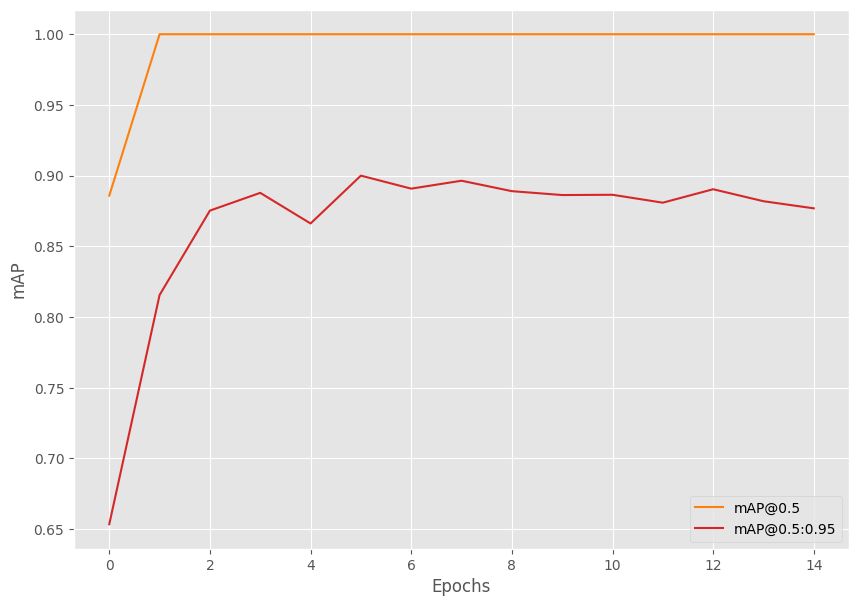

In [ ]:
plt.style.use('ggplot')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value

# Function for running validation iterations.
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()

    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

if __name__ == '__main__':
    os.makedirs('outputs', exist_ok=True)
    train_dataset = create_train_dataset(TRAIN_DIR)
    valid_dataset = create_valid_dataset(VALID_DIR)
    train_loader = create_train_loader(train_dataset, NUM_WORKERS)
    valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(valid_dataset)}\n")

    # Initialize the model and move to the computation device.
    model = create_model(num_classes=NUM_CLASSES, size=RESIZE_TO)
    model = model.to(DEVICE)
    print(model)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, nesterov=True)
    scheduler = StepLR(
        optimizer=optimizer, step_size=15, gamma=0.1, verbose=True
    )

    # To monitor training loss
    train_loss_hist = Averager()
    # To store training loss and mAP values.
    train_loss_list = []
    map_50_list = []
    map_list = []

    # Mame to save the trained model with.
    MODEL_NAME = 'model'

    # Whether to show transformed images from data loader or not.
    if VISUALIZE_TRANSFORMED_IMAGES:
        from custom_utils import show_tranformed_image
        show_tranformed_image(train_loader)

    # To save best model.
    save_best_model = SaveBestModel()

    # Training loop.
    for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

        # Reset the training loss histories for the current epoch.
        train_loss_hist.reset()

        # Start timer and carry out training and validation.
        start = time.time()
        train_loss = train(train_loader, model)
        metric_summary = validate(valid_loader, model)
        print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
        print(f"Epoch #{epoch+1} mAP: {metric_summary['map']}")
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

        train_loss_list.append(train_loss)
        map_50_list.append(metric_summary['map_50'])
        map_list.append(metric_summary['map'])

        # save the best model till now.
        save_best_model(
            model, float(metric_summary['map']), epoch, 'outputs'
        )
        # Save the current epoch model.
        save_model(epoch, model, optimizer)

        # Save loss plot.
        save_loss_plot(OUT_DIR, train_loss_list)

        # Save mAP plot.
        save_mAP(OUT_DIR, map_50_list, map_list)
        scheduler.step()

Test instances: 9
(640, 640, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


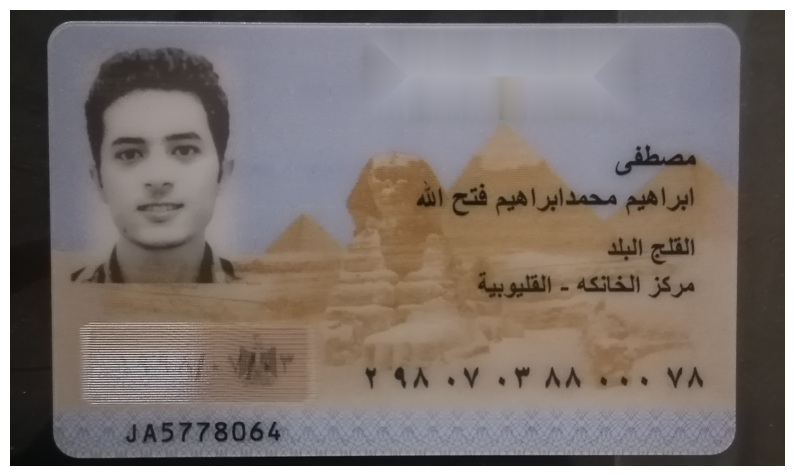

Image 1 done...
--------------------------------------------------
(640, 640, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


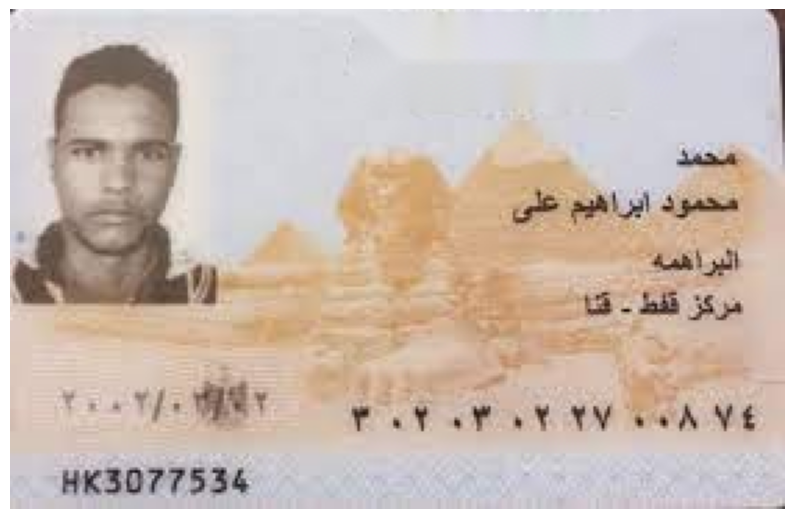

Image 2 done...
--------------------------------------------------
(640, 640, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


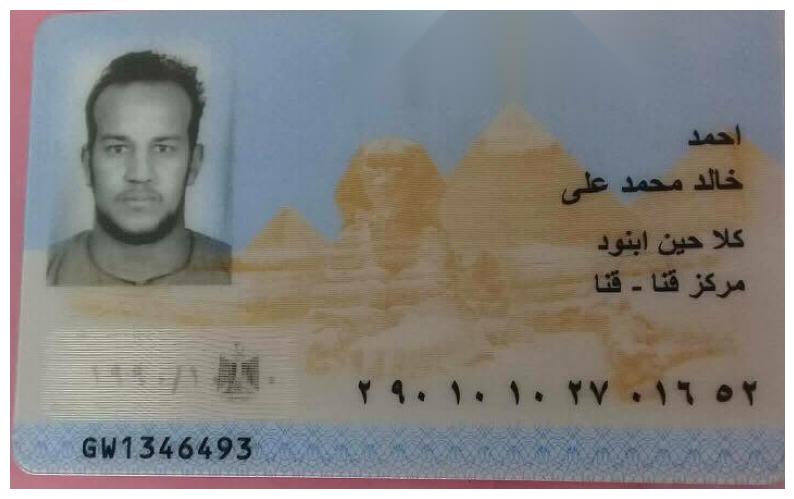

Image 3 done...
--------------------------------------------------
(640, 640, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


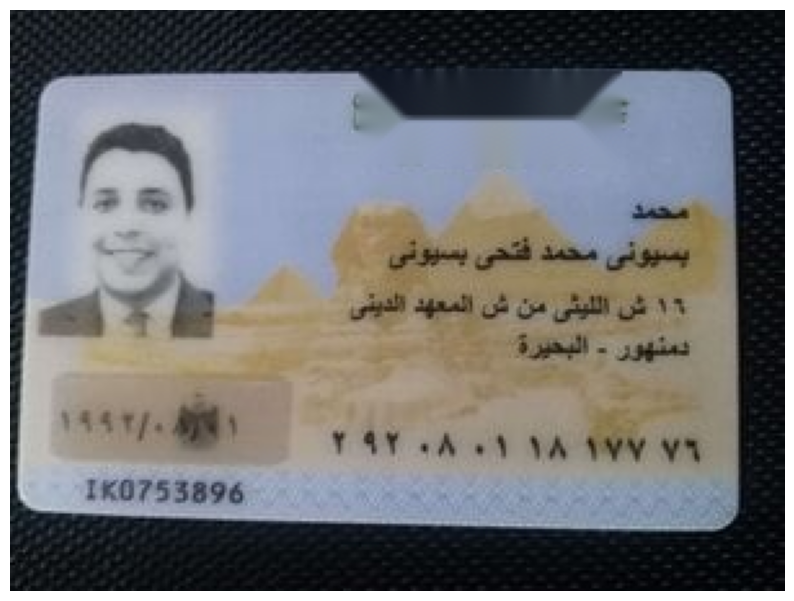

Image 4 done...
--------------------------------------------------
(640, 640, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


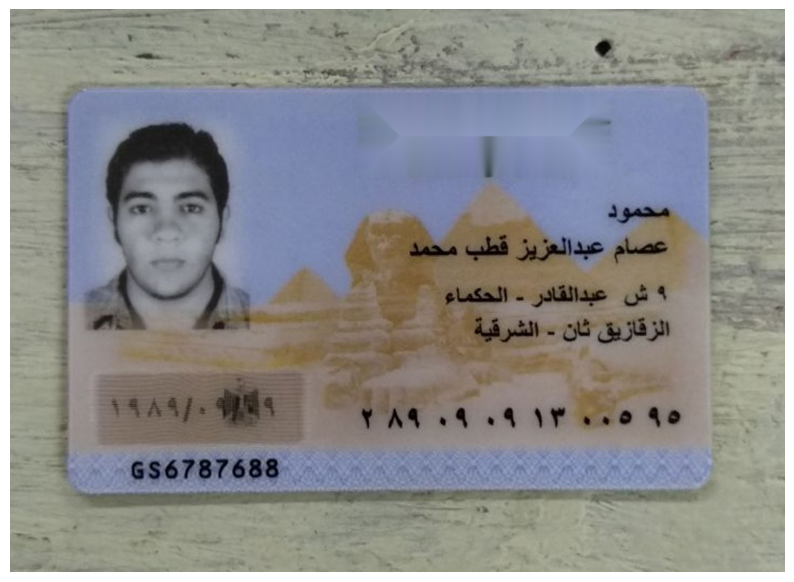

Image 5 done...
--------------------------------------------------
(640, 640, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


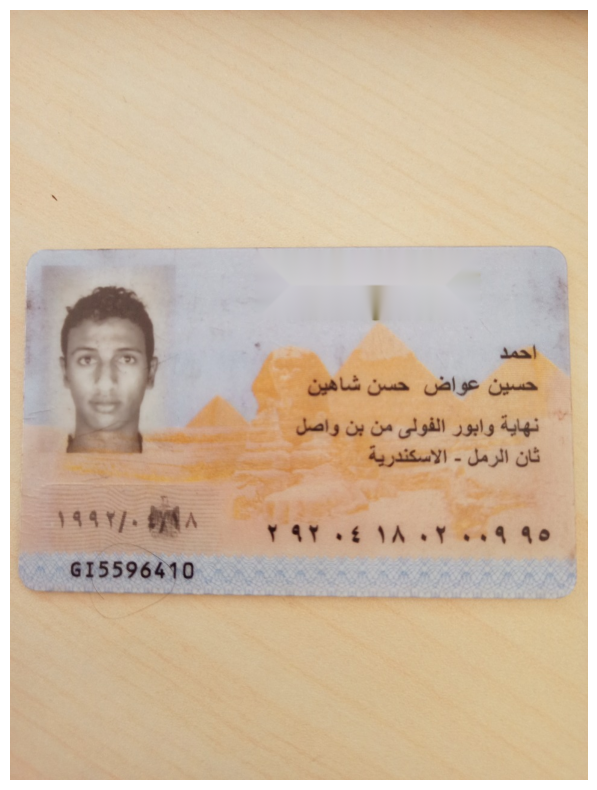

Image 6 done...
--------------------------------------------------
(640, 640, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


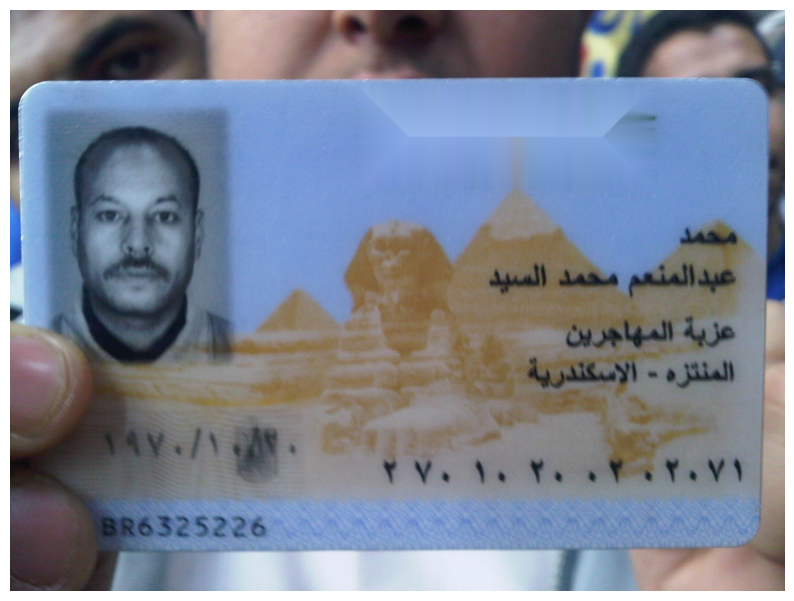

Image 7 done...
--------------------------------------------------
(640, 640, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


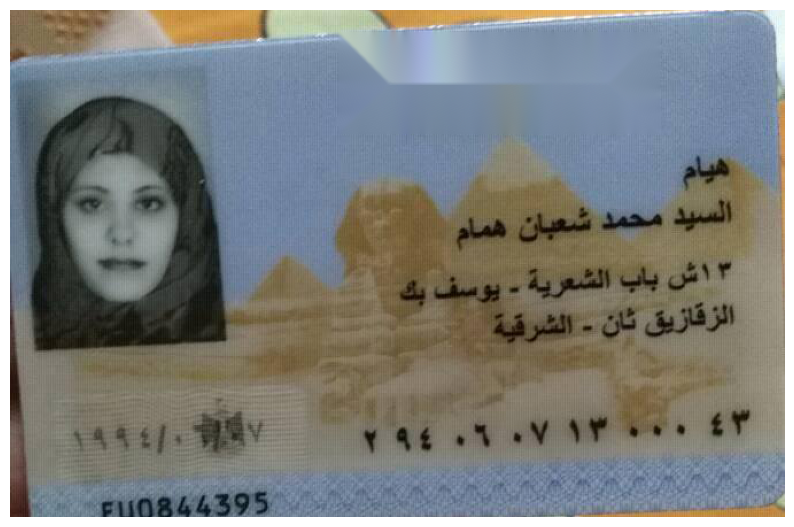

Image 8 done...
--------------------------------------------------
(640, 640, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


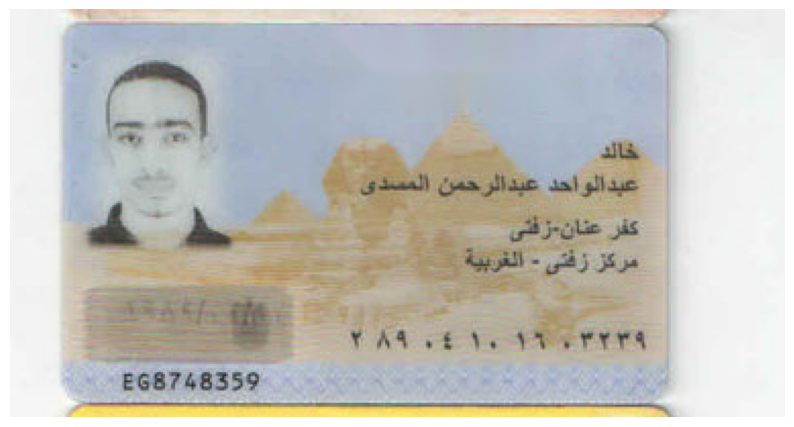

Image 9 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [ ]:
np.random.seed(42)

# Configuration
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2
OUT_DIR = '/content/outputs'


def extract_dominant_color(image, mask):
    # Extract RGB values of the pixels in the masked region
    masked_pixels = image[mask > 0]
    # Reshape to fit KMeans input format
    reshaped_pixels = masked_pixels.reshape(-1, 3)
    # Determine the number of clusters (colors) to identify
    num_clusters = 1
    if len(reshaped_pixels) > 100:
        num_clusters = 3
    # Apply KMeans clustering to find dominant color(s)
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(reshaped_pixels)
    dominant_color = kmeans.cluster_centers_[0]
    return dominant_color.astype(np.uint8)

# Load the best model and trained weights.
model = create_model(num_classes=NUM_CLASSES, size=640)
checkpoint = torch.load(OUT_DIR + '/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# Directory where all the images are present.
DIR_TEST = '/content/gdrive/MyDrive/finall/input'
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")

for i in range(len(test_images)):
    # Get the image file name for saving output later on.
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    image = cv2.resize(image, (640, 640))
    print(image.shape)
    # BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # Make the pixel range between 0 and 1.
    image /= 255.0
    # Bring color channels to front (H, W, C) => (C, H, W).
    image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # Convert to tensor.
    image_input = torch.tensor(image_input, dtype=torch.float).cuda()
    # Add batch dimension.
    image_input = torch.unsqueeze(image_input, 0)
    start_time = time.time()
    # Predictions
    with torch.no_grad():
        outputs = model(image_input.to(DEVICE))
    end_time = time.time()

    # Load all detection to CPU for further operations.
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes.
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # Filter out boxes according to `detection_threshold`.
        boxes = boxes[scores >= 0.50].astype(np.int32)
        draw_boxes = boxes.copy()
        # Get all the predicited class names.
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # Inpaint the region with the highest probability.
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            # Recale boxes.
            xmin = int((box[0] / image.shape[1]) * orig_image.shape[1])
            ymin = int((box[1] / image.shape[0]) * orig_image.shape[0])
            xmax = int((box[2] / image.shape[1]) * orig_image.shape[1])
            ymax = int((box[3] / image.shape[0]) * orig_image.shape[0])
            # Create a single-channel mask for the box with the highest score.
            mask = np.zeros_like(orig_image[:,:,0])
            mask[ymin:ymax, xmin:xmax] = 255
            # Extract dominant color of the masked region
            dominant_color = extract_dominant_color(orig_image, mask)
            # Inpaint the region inside the bounding box with the dominant color
            orig_image = cv2.inpaint(orig_image, mask, 3, cv2.INPAINT_TELEA, dst=dominant_color)

        # Display the result using matplotlib
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
        plt.show()

    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')

# **Required Function:**

In [ ]:
np.random.seed(42)

def extract_dominant_color(image, mask):
    # Extract RGB values of the pixels in the masked region
    masked_pixels = image[mask > 0]
    # Reshape to fit KMeans input format
    reshaped_pixels = masked_pixels.reshape(-1, 3)
    # Determine the number of clusters (colors) to identify
    num_clusters = 1
    if len(reshaped_pixels) > 100:
        num_clusters = 3
    # Apply KMeans clustering to find dominant color(s)
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)  # Set n_init explicitly to suppress warning
    kmeans.fit(reshaped_pixels)
    dominant_color = kmeans.cluster_centers_[0]
    return dominant_color.astype(np.uint8)

def process_image(input_image_path, output_image_path):
    # Load the best model and trained weights
    model = create_model(num_classes=NUM_CLASSES, size=640)
    checkpoint = torch.load('/content/outputs/best_model.pth', map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE).eval()

    # Load the image
    image = cv2.imread(input_image_path)
    if image is None:
        print(f"Error: Image at {input_image_path} not loaded properly.")
        return
    orig_image = image.copy()
    image = cv2.resize(image, (640, 640))

    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # Normalize the image
    image /= 255.0
    # Bring color channels to front (H, W, C) => (C, H, W)
    image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # Convert to tensor
    image_input = torch.tensor(image_input, dtype=torch.float).cuda()
    # Add batch dimension
    image_input = torch.unsqueeze(image_input, 0)

    # Predictions
    with torch.no_grad():
        outputs = model(image_input.to(DEVICE))

    # Load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # Filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= 0.5].astype(np.int32)
        draw_boxes = boxes.copy()
        # Get all the predicted class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # Inpaint the region with the highest probability
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            # Rescale boxes
            xmin = int((box[0] / image.shape[1]) * orig_image.shape[1])
            ymin = int((box[1] / image.shape[0]) * orig_image.shape[0])
            xmax = int((box[2] / image.shape[1]) * orig_image.shape[1])
            ymax = int((box[3] / image.shape[0]) * orig_image.shape[0])
            # Create a single-channel mask for the box with the highest score
            mask = np.zeros_like(orig_image[:,:,0])
            mask[ymin:ymax, xmin:xmax] = 255
            # Extract dominant color of the masked region
            dominant_color = extract_dominant_color(orig_image, mask)
            # Inpaint the region inside the bounding box with the dominant color
            orig_image = cv2.inpaint(orig_image, mask, 3, cv2.INPAINT_TELEA)
            orig_image[mask > 0] = dominant_color

        # Save the inpainted image using matplotlib
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
        plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        print(f"Inpainted image saved to {output_image_path}")

if __name__ == '__main__':
    input_image_path = '/content/images/test/7.jpg'  # Path to the input image
    output_image_path = '/content/outputs/output_image.jpg'  # Path to save the output image
    process_image(input_image_path, output_image_path)

Inpainted image saved to /content/outputs/output_image.jpg


# **Second Approach: SIFT (Scale-Invariant Feature Transform)**

SIFT, which stands for Scale-Invariant Feature Transform, is a feature detection algorithm used in computer vision and image processing. It is designed to detect and describe local features in images, which are robust to changes in scale, rotation, illumination, and viewpoint. Here's a brief overview of how SIFT works:

Scale-space extrema detection: SIFT detects keypoints by searching for local extrema in the scale space of an image. It uses a Gaussian scale space to represent the image at different scales.

Keypoint localization: Once potential keypoints are identified, SIFT performs detailed localization to accurately determine their locations and scales. This is done by fitting a 3D quadratic function to the nearby pixels in the scale space.

Orientation assignment: Each keypoint is assigned a unique orientation based on the local image gradient directions. This step ensures that the keypoints are invariant to image rotation.

Keypoint descriptor generation: SIFT generates a descriptor for each keypoint based on the gradient magnitude and orientation of the surrounding image patch. This descriptor is a high-dimensional vector that encodes information about the local image structure.

Keypoint matching: Finally, SIFT matches keypoints between different images by comparing their descriptors using techniques like Euclidean distance or nearest-neighbor search. These matches can be used for tasks like image alignment, object recognition, and image stitching.


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def detect_logos(logos_dir, images_dir):
    # Create SIFT detector
    sift = cv2.SIFT_create()

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Load all logos and their keypoints/descriptors
    logos = []
    for logo_file in os.listdir(logos_dir):
        logo_path = os.path.join(logos_dir, logo_file)
        logo = cv2.imread(logo_path, cv2.IMREAD_GRAYSCALE)
        if logo is None:
            continue
        keypoints_logo, descriptors_logo = sift.detectAndCompute(logo, None)
        logos.append((logo, keypoints_logo, descriptors_logo))

    # Process each image in the images directory
    for image_file in os.listdir(images_dir):
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue
        color_image = cv2.imread(image_path)  # Load color image for displaying matches

        keypoints_image, descriptors_image = sift.detectAndCompute(image, None)

        best_match = None
        best_matches = None
        best_logo = None
        best_keypoints_logo = None

        for logo, keypoints_logo, descriptors_logo in logos:
            # Match descriptors
            matches = bf.match(descriptors_logo, descriptors_image)

            # Sort them in the order of their distance
            matches = sorted(matches, key=lambda x: x.distance)

            if best_match is None or len(matches) > len(best_matches):
                best_match = matches
                best_matches = matches
                best_logo = logo
                best_keypoints_logo = keypoints_logo

        if best_logo is not None:
            # Draw matches
            result = cv2.drawMatches(best_logo, best_keypoints_logo, color_image, keypoints_image, best_matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

            # Display the result using matplotlib
            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            plt.title(f'Best Matched Logo in {image_file}')
            plt.axis('off')
            plt.show()

if __name__ == '__main__':
    logos_dir = '/content/gdrive/MyDrive/logos'  # Path to the directory containing logo images
    images_dir = '/content/gdrive/MyDrive/test_set'  # Path to the directory containing images to be processed
    detect_logos(logos_dir, images_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def detect_logos_and_inpaint(logos_dir, input_image_path, output_image_path):
    # Create SIFT detector
    sift = cv2.SIFT_create()

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Load all logos and their keypoints/descriptors
    logos = []
    for logo_file in os.listdir(logos_dir):
        logo_path = os.path.join(logos_dir, logo_file)
        logo = cv2.imread(logo_path, cv2.IMREAD_GRAYSCALE)
        if logo is None:
            continue
        keypoints_logo, descriptors_logo = sift.detectAndCompute(logo, None)
        logos.append((logo, keypoints_logo, descriptors_logo))

    # Load the input image
    image = cv2.imread(input_image_path)
    if image is None:
        print(f"Error: Image at {input_image_path} not loaded properly.")
        return
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    keypoints_image, descriptors_image = sift.detectAndCompute(gray_image, None)

    best_match = None
    best_matches = None
    best_logo = None
    best_keypoints_logo = None

    for logo, keypoints_logo, descriptors_logo in logos:
        # Match descriptors
        matches = bf.match(descriptors_logo, descriptors_image)

        # Sort them in the order of their distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Find the best match
        if best_match is None or (len(matches) > 0 and matches[0].distance < best_match[0].distance):
            best_match = matches
            best_matches = matches
            best_logo = logo
            best_keypoints_logo = keypoints_logo

    if best_logo is not None and len(best_matches) >= 4:
        src_pts = np.float32([best_keypoints_logo[m.queryIdx].pt for m in best_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_image[m.trainIdx].pt for m in best_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is not None:
            h, w = best_logo.shape
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, M)

            # Create a mask for the region to be inpainted
            mask = np.zeros_like(gray_image)
            cv2.fillPoly(mask, [np.int32(dst)], 255)

            # Inpaint the detected region
            inpainted_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

            # Save the inpainted image using matplotlib
            plt.figure(figsize=(12, 8))
            plt.axis('off')
            plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
            plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
            plt.close()
            print(f"Inpainted image saved to {output_image_path}")

if __name__ == '__main__':
    logos_dir = '/content/gdrive/MyDrive/logos'  # Path to the directory containing logo images
    input_image_path = '/content/gdrive/MyDrive/test_set/input_image.jpg'  # Path to the input image
    output_image_path = '/content/gdrive/MyDrive/test_set/output_image.jpg'  # Path to save the output image
    detect_logos_and_inpaint(logos_dir, input_image_path, output_image_path)

Output hidden; open in https://colab.research.google.com to view.

# **Required Function:**

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def detect_logos_and_inpaint(logos_dir, input_image_path, output_image_path):
    # Create SIFT detector
    sift = cv2.SIFT_create()

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Load all logos and their keypoints/descriptors
    logos = []
    for logo_file in os.listdir(logos_dir):
        logo_path = os.path.join(logos_dir, logo_file)
        logo = cv2.imread(logo_path, cv2.IMREAD_GRAYSCALE)
        if logo is None:
            continue
        keypoints_logo, descriptors_logo = sift.detectAndCompute(logo, None)
        logos.append((logo, keypoints_logo, descriptors_logo))

    # Load the input image
    image = cv2.imread(input_image_path)
    if image is None:
        print(f"Error: Image at {input_image_path} not loaded properly.")
        return
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    keypoints_image, descriptors_image = sift.detectAndCompute(gray_image, None)

    for logo, keypoints_logo, descriptors_logo in logos:
        # Match descriptors
        matches = bf.match(descriptors_logo, descriptors_image)

        # Sort them in the order of their distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Draw matches
        if len(matches) >= 4:
            src_pts = np.float32([keypoints_logo[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints_image[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

            # Find homography
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            if M is not None:
                h, w = logo.shape
                pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
                dst = cv2.perspectiveTransform(pts, M)

                # Create a mask for the region to be inpainted
                mask = np.zeros_like(gray_image)
                cv2.fillPoly(mask, [np.int32(dst)], 255)

                # Inpaint the detected region
                inpainted_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

                # Save the inpainted image using matplotlib
                plt.figure(figsize=(12, 8))
                plt.axis('off')
                plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
                plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
                plt.close()
                print(f"Inpainted image saved to {output_image_path}")
                return  # Stop after processing the first matched logo

if __name__ == '__main__':
    logos_dir = '/content/gdrive/MyDrive/logos'  # Path to the directory containing logo images
    input_image_path = '/content/images/test/7.jpg'  # Path to the input image
    output_image_path = '/content/outputs'  # Path to save the output image
    detect_logos_and_inpaint(logos_dir, input_image_path, output_image_path)

Inpainted image saved to /content/outputs


# **Future Work**
1 - I would like to explore the possibility of adding an ESRGAN (Enhanced Super-Resolution Generative Adversarial Networks) to the pipeline. It will work great with low quality images and it works great with enhancing text for further detection by OCR models.

2 - I would like to experiment with edge detection algorithms to crop the images to decrease the image space to be worked with.

3 - I would like to experiment with different color spaces as I found it particularly useful to experiment with different color spaces during training (to make the green color more separable than the rest of the space, hence more detectable.)